In [2]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input,BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import cifar100
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('tf')   # very important command setting the dimension 
# For 2D data (e.g. image), "tf" assumes (rows, cols, channels) 
#while "th" assumes (channels, rows, cols).
# The dimensionality has been set at 100 for consistency with other GAN implementations. 
# But 10 works better here
latent_dim = 100
# Load cifar data
(X_train, y_train), (X_valid, y_valid) = cifar100.load_data()


print(X_train.shape)
# Use Adam as the Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

169009152/169001437 [==============================] - 49s 0us/step
(50000, 32, 32, 3)


In [3]:
xtrain=(X_train.astype('float32'))/255
xvalid=(X_valid.astype('float32'))/255

In [6]:
generator = Sequential()

# Transforms the input into a 8 × 8 128-channel feature map
generator.add(Dense(128*8*8, input_dim=latent_dim))

generator.add(LeakyReLU(0.2))
generator.add(Reshape((8,8,128)))
#generator.add(Conv2D(128, kernel_size=(5, 5), padding='same'))
#generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))

# Produces a 28 × 28 1-channel feature map (shape of a MNIST image)
generator.add(Conv2D(3, kernel_size=(5, 5), padding='same', activation='sigmoid'))
print(generator.summary()) 
generator.compile(loss='binary_crossentropy', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        204864    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        102464    
__________

In [7]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=(32,32,3), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [8]:
discriminator.trainable = False
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [9]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 32, 32, 3)         1139523   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 217985    
Total params: 1,357,508
Trainable params: 1,139,523
Non-trainable params: 217,985
_________________________________________________________________


In [10]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)


In [11]:
epochs = 30
batchSize = 128
batchCount = X_train.shape[0] // batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = xtrain[np.random.randint(0, xtrain.shape[0], size=batchSize)]
        #randomly select images from Mnist data
        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

  0%|          | 0/390 [00:00<?, ?it/s]

Epochs: 30
Batch size: 128
Batches per epoch: 390
--------------- Epoch 1 ---------------


  0%|          | 1/390 [00:00<00:42,  9.16it/s]

--------------- Epoch 2 ---------------


  0%|          | 1/390 [00:00<00:42,  9.12it/s]

--------------- Epoch 3 ---------------


  0%|          | 1/390 [00:00<00:43,  9.03it/s]

--------------- Epoch 4 ---------------


  0%|          | 1/390 [00:00<00:42,  9.18it/s]

--------------- Epoch 5 ---------------


  0%|          | 1/390 [00:00<00:43,  9.03it/s]

--------------- Epoch 6 ---------------


  0%|          | 1/390 [00:00<00:41,  9.27it/s]

--------------- Epoch 7 ---------------


  0%|          | 1/390 [00:00<00:42,  9.09it/s]

--------------- Epoch 8 ---------------


  0%|          | 1/390 [00:00<00:42,  9.24it/s]

--------------- Epoch 9 ---------------


  0%|          | 1/390 [00:00<00:42,  9.07it/s]

--------------- Epoch 10 ---------------


  0%|          | 1/390 [00:00<00:42,  9.18it/s]

--------------- Epoch 11 ---------------


  0%|          | 1/390 [00:00<00:42,  9.18it/s]

--------------- Epoch 12 ---------------


  0%|          | 1/390 [00:00<00:41,  9.28it/s]

--------------- Epoch 13 ---------------


  0%|          | 1/390 [00:00<00:42,  9.21it/s]

--------------- Epoch 14 ---------------


  0%|          | 1/390 [00:00<00:42,  9.24it/s]

--------------- Epoch 15 ---------------


  0%|          | 1/390 [00:00<00:42,  9.17it/s]

--------------- Epoch 16 ---------------


  0%|          | 1/390 [00:00<00:43,  8.93it/s]

--------------- Epoch 17 ---------------


  0%|          | 1/390 [00:00<00:42,  9.21it/s]

--------------- Epoch 18 ---------------


  0%|          | 1/390 [00:00<00:42,  9.06it/s]

--------------- Epoch 19 ---------------


  0%|          | 1/390 [00:00<00:43,  8.91it/s]

--------------- Epoch 20 ---------------


  0%|          | 1/390 [00:00<00:42,  9.10it/s]

--------------- Epoch 21 ---------------


  0%|          | 1/390 [00:00<00:43,  8.93it/s]

--------------- Epoch 22 ---------------


  0%|          | 1/390 [00:00<00:42,  9.18it/s]

--------------- Epoch 23 ---------------


  0%|          | 1/390 [00:00<00:41,  9.26it/s]

--------------- Epoch 24 ---------------


  0%|          | 1/390 [00:00<00:41,  9.32it/s]

--------------- Epoch 25 ---------------


  0%|          | 1/390 [00:00<00:42,  9.06it/s]

--------------- Epoch 26 ---------------


  0%|          | 1/390 [00:00<00:42,  9.17it/s]

--------------- Epoch 27 ---------------


  0%|          | 1/390 [00:00<00:42,  9.10it/s]

--------------- Epoch 28 ---------------


  0%|          | 1/390 [00:00<00:42,  9.19it/s]

--------------- Epoch 29 ---------------


  0%|          | 1/390 [00:00<00:42,  9.19it/s]

--------------- Epoch 30 ---------------


100%|██████████| 390/390 [00:42<00:00,  9.17it/s]


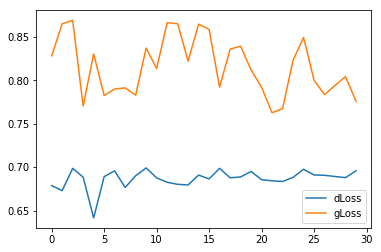

In [12]:


plt.plot(dLosses,label='dLoss')
plt.plot(gLosses,label='gLoss')
plt.legend()



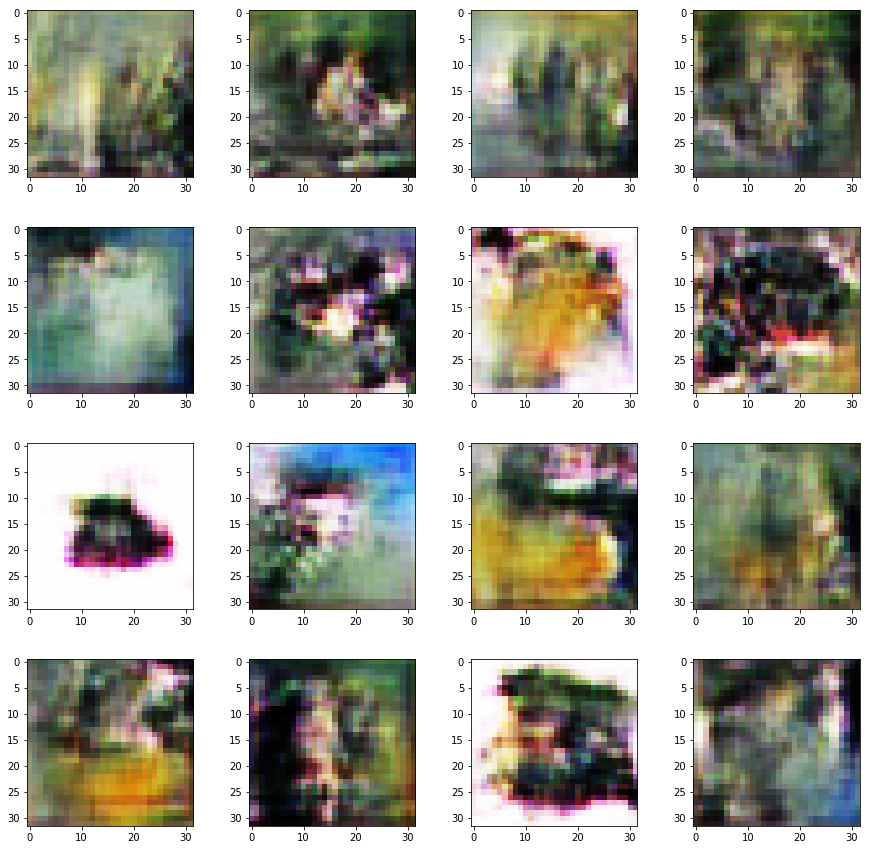

In [13]:


fig, axes = plt.subplots(4, 4,figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i,ax in enumerate(axes.flat):
    ax.imshow(generatedImages[i])



In [14]:
noise=np.random.normal(0,1,[16,100])

In [15]:
genimgs=generator.predict(noise)

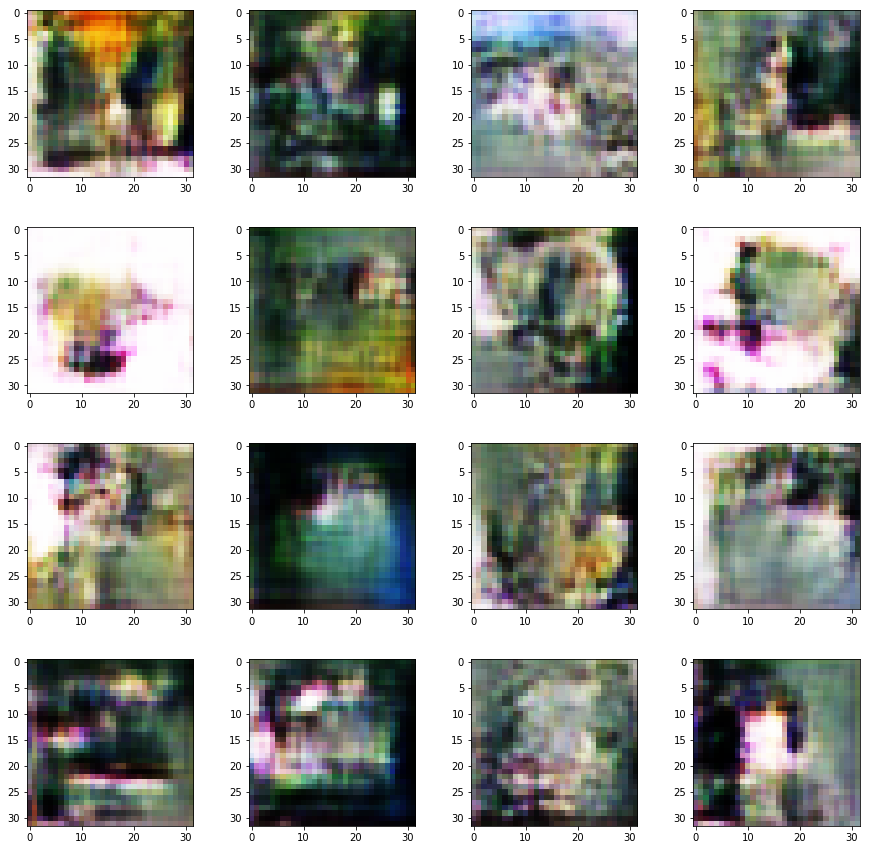

In [16]:
fig, axes = plt.subplots(4, 4,figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i,ax in enumerate(axes.flat):
    ax.imshow(genimgs[i])


In [ ]:
>>> Done<<<